# Box Regression - 2. AI Training

### Table of Contents

* [Experiment - Data from Training](#boxregression)
    * [Librairies](#librairies)
    * [Parameters](#parameters)
    * [Data Loading](#loaddata)
        * [Inspect Data](#inspectdata)
        * [Folder Structure](#folderstructure) 
    * [Model](#model)
        * [Architecture](#architecture)
        * [Loss : IoU](#loss)
        * [Metric & Callbacks](#metriccallbacks)
    * [Compilation](#compilation)
        * [Training](#training)
        * [Learning Curves](#curves)
    * [Main](#main)
    
* [Best Model](#better)
    * [Test Loss](#test)
    * [Prediction Visualization](#inference)
    * [Source of Inaccuracy](#inacc)

**Work inspired by** ***Sanjeev Tripathi*** : https://github.com/sanjeev309/deep_bbox_regression_keras/
## Experiment - Data from Training <a class="anchor" id="boxregression"></a>

### Librairies  <a class="anchor" id="librairies"></a>

In [3]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import callbacks, regularizers
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as opt

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import time
import sys
import os
import cv2

### Parameters  <a class="anchor" id="parameters"></a>

Some parameters to train and analyse different parametrization of the deep learning architecture :
- **PATH** : Directory of the project (storing data, results and so on...)
- **LR_LIST** : list of learning rate for training
- **BATCH_LIST** : list of batch size for training
- **EPOCHS** :Maximal number of epochs for training
- **ADAPTATIVE_LR** : If uses the callback *ReduceLROnPlateau* (True = Decreasing learning rate, False = fixed)

The IA will be trained on every combination of elements between LR_LIST (learning rates) and BATCH_LIST (batch sizes)

In [4]:
PATH = "D:/Aurelien/Documents/Aurelien/University/Master 1 (2021-2022)/MA1 - Q2/Projets/Box Regression"
os.chdir(PATH)

LR_LIST = [1e-01, 1e-02, 1e-03, 1e-04]
BATCH_LIST = [4096, 1024, 256, 64, 16, 4]

EPOCHS = 30
ADAPTATIVE_LR = False

### Data Loading <a class="anchor" id="loaddata"></a>

In [5]:
X_train = np.load('db/train/' + '.train_data.npy')
Y_train = np.load('db/train/' + '.train_target.npy')

X_valid = np.load('db/valid/' + '.valid_data.npy')
Y_valid = np.load('db/valid/' + '.valid_target.npy')

IMAGE_DIMENSION = X_train.shape[1]

#### Inspect Data  <a class="anchor" id="inspectdata"></a>

Training shape :
 - Data   : (8000, 128, 128, 1)
 - Labels : (8000, 4)
Validation shape
 - Data   : (1000, 128, 128, 1)
 - Labels : (1000, 4)


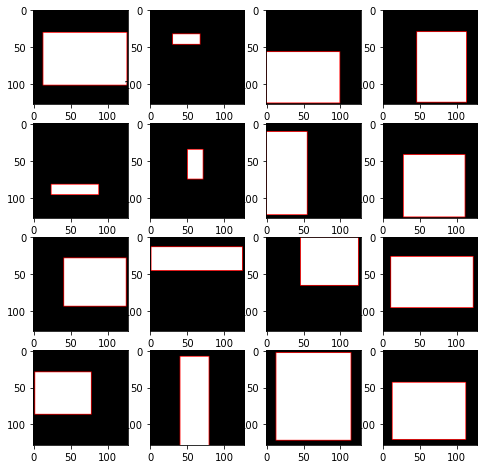

In [6]:
def convert_grayscale_to_rgb(gray):
    rgb_image = np.stack((gray,gray,gray),axis=2)
    return rgb_image[:,:,:,-1]

print("Training shape :")
print(f" - Data   : {X_train.shape}")    # (nbr_image, x_size, y_size, channels)
print(f" - Labels : {Y_train.shape}")    # (nbr_image, nbr_coord)

print("Validation shape")
print(f" - Data   : {X_valid.shape}")    # (nbr_image, x_size, y_size, channels)
print(f" - Labels : {Y_valid.shape}")    # (nbr_image, nbr_coord)

plt.figure(figsize=(8,8))
for i, image in enumerate(X_train[0:16]):
    x1,y1,x2,y2 = np.split(Y_train[i]*IMAGE_DIMENSION, indices_or_sections=4)
    im = convert_grayscale_to_rgb(image)
    im = cv2.rectangle(im,(int(x1),int(y1)),(int(x2),int(y2)), 1, 1)
    plt.subplot2grid((4,4),(i//4,i%4))
    plt.imshow(im) 

#### Folder Structure <a class="anchor" id="folderstructure"></a>

Recreate folders to store models, results and so on...

In [7]:
def remove(folder):
    try:
        shutil.rmtree(folder)
    except:
        print(f'Error deleting directory : {folder}', file=sys.stderr)

remove('./checkpoints')
remove('./models')
remove('./results')
remove('./pictures')

os.makedirs('./checkpoints')
os.makedirs('./models')
os.makedirs('./results')
os.makedirs('./pictures')

### Model   <a class="anchor" id="model"></a>

#### Architecture   <a class="anchor" id="architecture"></a>

Creates a classic small sequential architecture composed of convolution layers to extract image informations (ie. patterns) and maxpooling to reduce the image size by factor 4 to have an acceptable dense layer.

In [8]:
def create_model():
    model = Sequential()
    model.add(MaxPooling2D(pool_size=(2, 2), input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION,1)))
    model.add(Conv2D(4, kernel_size=3, strides=(1,1), activation = 'relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(4, kernel_size=3, strides=(1,1), activation = 'relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16))
    model.add(Dense(4))
    return model

In [9]:
create_model().summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         148       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
____

#### Loss definition : Intersection over Union (IoU)  <a class="anchor" id="loss"></a>

This function is taken from : https://github.com/sanjeev309/deep_bbox_regression_keras/blob/master/keras_bbox_regression.ipynb

It simply computes the ratio between the intersection area and union area with prediction box and labelled one.

In [10]:
def iou_loss(y_true, y_pred):
    # iou loss for bounding box prediction
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union
    
    # loss for the iou value
    iou_loss = 1-iou

    return iou_loss

#### Metric & Callbacks <a class="anchor" id="metriccallbacks"></a>

Definition of the callbacks used in the model :
- **ReduceLROnPlateau** : Reduce learning rate if stagnation (ie. oscillations in loss curves) (if ADAPTATIVE_LR = True)
- **EarlyStopping** : Stop the training after a certain number of epochs without improvement
- **CSVLogger** : Store training results into a log file
- **ModelCheckpoint** : Store checkpoint of the model, the restore older version (older epochs)

In [11]:
optimizer = opt.SGD(learning_rate = 1e-01)

# Use to print the learning rate at each epoch (useful if adapta)
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(np.float32) 
    return lr
lr_metric = get_lr_metric(optimizer)


# Defining callbacks to reduce learning rate if oscillations & Stop if stopping improvement
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-04)
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-04, patience=4)

# Function that returns a list of callbacks for the model and creating folder to save checkpoint of the model
def update_callback_logs(it, lr, batch):
    csv_logger = callbacks.CSVLogger('results/lr_' + str(lr) + '-batch_' + str(batch) + '-it_' + str(it) + '.log')
    try:
        os.makedirs('./checkpoints/batch_' + str(batch) + '_it_' + str(it))
    except:
        pass
    checkpoint_filepath = './checkpoints/batch_' + str(batch) + '_it_' + str(it) 
    checkpoint_filepath += '/lr_{lr:.5f}-ep_{epoch:2d}-loss_{loss:.4f}.hdf5'
    checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, 
                                           monitor='val_loss', mode='min', save_best_only=True)
    if ADAPTATIVE_LR:
        return [early_stop, reduce_lr, csv_logger, checkpoint]
    else:
        return [early_stop, csv_logger, checkpoint]

### Compilation  <a class="anchor" id="compilation"></a>

#### Training <a class="anchor" id="training"></a>

Fonction to train a model with a certain learning rate and batch size. The iteration (it) parameter is only used to save model without overwriting the previous iterations (the format name of the saved file used it, lr and batch size).

In [12]:
def train_new_model(it, lr, batch_size):
    optimizer = opt.SGD(learning_rate = lr)                                                   # Optimiser & Learning rate
    model = create_model()                                                                    # Model architecture (layers)
    callback_list = update_callback_logs(it, lr, batch_size)                                  # List of callbacks
    model.compile(loss=iou_loss, optimizer=optimizer, metrics=[lr_metric])                    # Loss (iou) and metrics
    H = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),                       # Training
                  epochs=EPOCHS ,batch_size=batch_size, callbacks = callback_list)                             
    model.save("models/lr_" + str(lr) + "batch_" + str(batch_size) + '_it_' + str(it) +".h5") # Save     
    plot_model_history(H, it, lr, batch_size)                                                 # Plot loss curves
    del model                                                                                 # Delete the model
    return len(H.history['loss'])  # Return number of training epochs (useful if early stopping)

#### Learning Curves <a class="anchor" id="curves"></a>

Plot the history of training and validation losses

In [13]:
def plot_model_history(H, it, lr, batch):
    N = len(H.history['loss'])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(2, N), H.history["loss"][2:], label="train_loss")
    plt.plot(np.arange(2, N), H.history["val_loss"][2:], label="val_loss")
    plt.title("Loss with batch size of " + str(batch) + " and learning rate " + str(lr))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig("results/lr_" + str(lr).replace('.',',') + "-batch_" + str(batch) + '-it_' + str(it))

### Main <a class="anchor" id="main"></a>

Main loop of the project :
- Iterates over each combinations of learning rate and batch size (defining at the beginning)
- Each combination is run 10 times to get reliable data in average
- Each training is timed and saved for further analysis

In [ ]:
for it in range(10):  # IT TAKES FEW HOURS WITH 10 ITERATIONS /!\
    for lr in LR_LIST:
        for batch_size in BATCH_LIST:
            print(f"\n\n ITERATION={it} : LR={lr} : BATCH SIZE={batch_size}\n")
            start = time.time()
            epochs = train_new_model(it, lr, batch_size)
            chrono = time.time() - start
            with open("results/.timing.txt", 'a') as f:
                print(f"Iteration {it} lr {lr} batch_size {batch_size} time {chrono:.2f} " 
                      f"nbr_epochs {epochs} time_by_epochs {chrono/epochs:.2f}", file=f)

# Best Model <a class="anchor" id="better"></a>

Training a model as best as possible. 

Either choose the best combination of batch size and learning rate or use a slightly too high learning rate with a *ReduceLROnPlateau* callback.

This model uses a decreasing learning rate thanks to the *ReduceLROnPlateau* callback.

In [38]:
LR = 1e-01
BATCH = 16
EPOCHS = 30

ADAPTATIVE_LR = True
it = 666



 LR=0.1 : BATCH SIZE=16

Train on 8000 samples, validate on 1000 samples
Epoch 1/30
8000/8000 [==============================] - 8s 1ms/sample - loss: 0.2464 - lr: 0.1000 - val_loss: 0.1721 - val_lr: 0.1000
Epoch 2/30
8000/8000 [==============================] - 6s 715us/sample - loss: 0.1722 - lr: 0.1000 - val_loss: 0.1513 - val_lr: 0.1000
Epoch 3/30
8000/8000 [==============================] - 5s 651us/sample - loss: 0.1370 - lr: 0.1000 - val_loss: 0.1231 - val_lr: 0.1000
Epoch 4/30
8000/8000 [==============================] - 4s 515us/sample - loss: 0.1195 - lr: 0.1000 - val_loss: 0.1019 - val_lr: 0.1000
Epoch 5/30
8000/8000 [==============================] - 4s 479us/sample - loss: 0.1136 - lr: 0.1000 - val_loss: 0.1133 - val_lr: 0.1000
Epoch 6/30
8000/8000 [==============================] - 5s 578us/sample - loss: 0.1114 - lr: 0.1000 - val_loss: 0.1285 - val_lr: 0.1000
Epoch 7/30
8000/8000 [==============================] - 4s 497us/sample - loss: 0.0727 - lr: 0.0500 - val_loss:

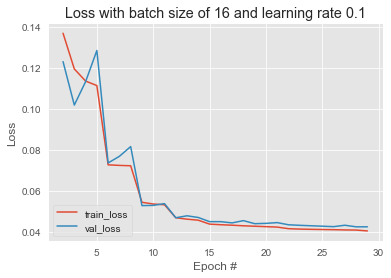

In [39]:
print(f"\n\n LR={LR} : BATCH SIZE={BATCH}\n")
start = time.time()
epochs = train_new_model(it, LR, BATCH)
end = time.time()
chrono = end-start
print(f"\n\nIteration {it} lr {LR} batch_size {BATCH} time {chrono:.2f} " 
      f"nbr_epochs {epochs} time_by_epochs {chrono/epochs:.2f}")

## Test Loss <a class="anchor" id="test"></a>

Load a model and the testing set to evaluate the model.

In [40]:
# Load a model
filename = 'lr_' + str(LR) + 'batch_' + str(BATCH) + '_it_' + str(it)
print("Loading model :", filename, end="\n\n")
model_name = './models/' + filename + '.h5'
infer_model = load_model(model_name, custom_objects={'iou_loss':iou_loss, 'lr':get_lr_metric(optimizer)})

# Load test dataset
X_test = np.load('db/test/' + '.test_data.npy')
y_test = np.load('db/test/' + '.test_target.npy')

score = infer_model.evaluate(X_test, y_test, verbose = 0) 

print('\n\nTest loss:', score[0]) 

Loading model : lr_0.1batch_16_it_666



Test loss: 0.045237343072891234


## Prediction Visualization <a class="anchor" id="test"></a>

Makes predictions on the testing set and visualize a sample of the results

In [41]:
# Make Predictions
prediction = infer_model.predict(X_test)
# Rescale to the size of image
scale = X_test.shape[1]
prediction *= scale

Test loss: 0.045237343072891234


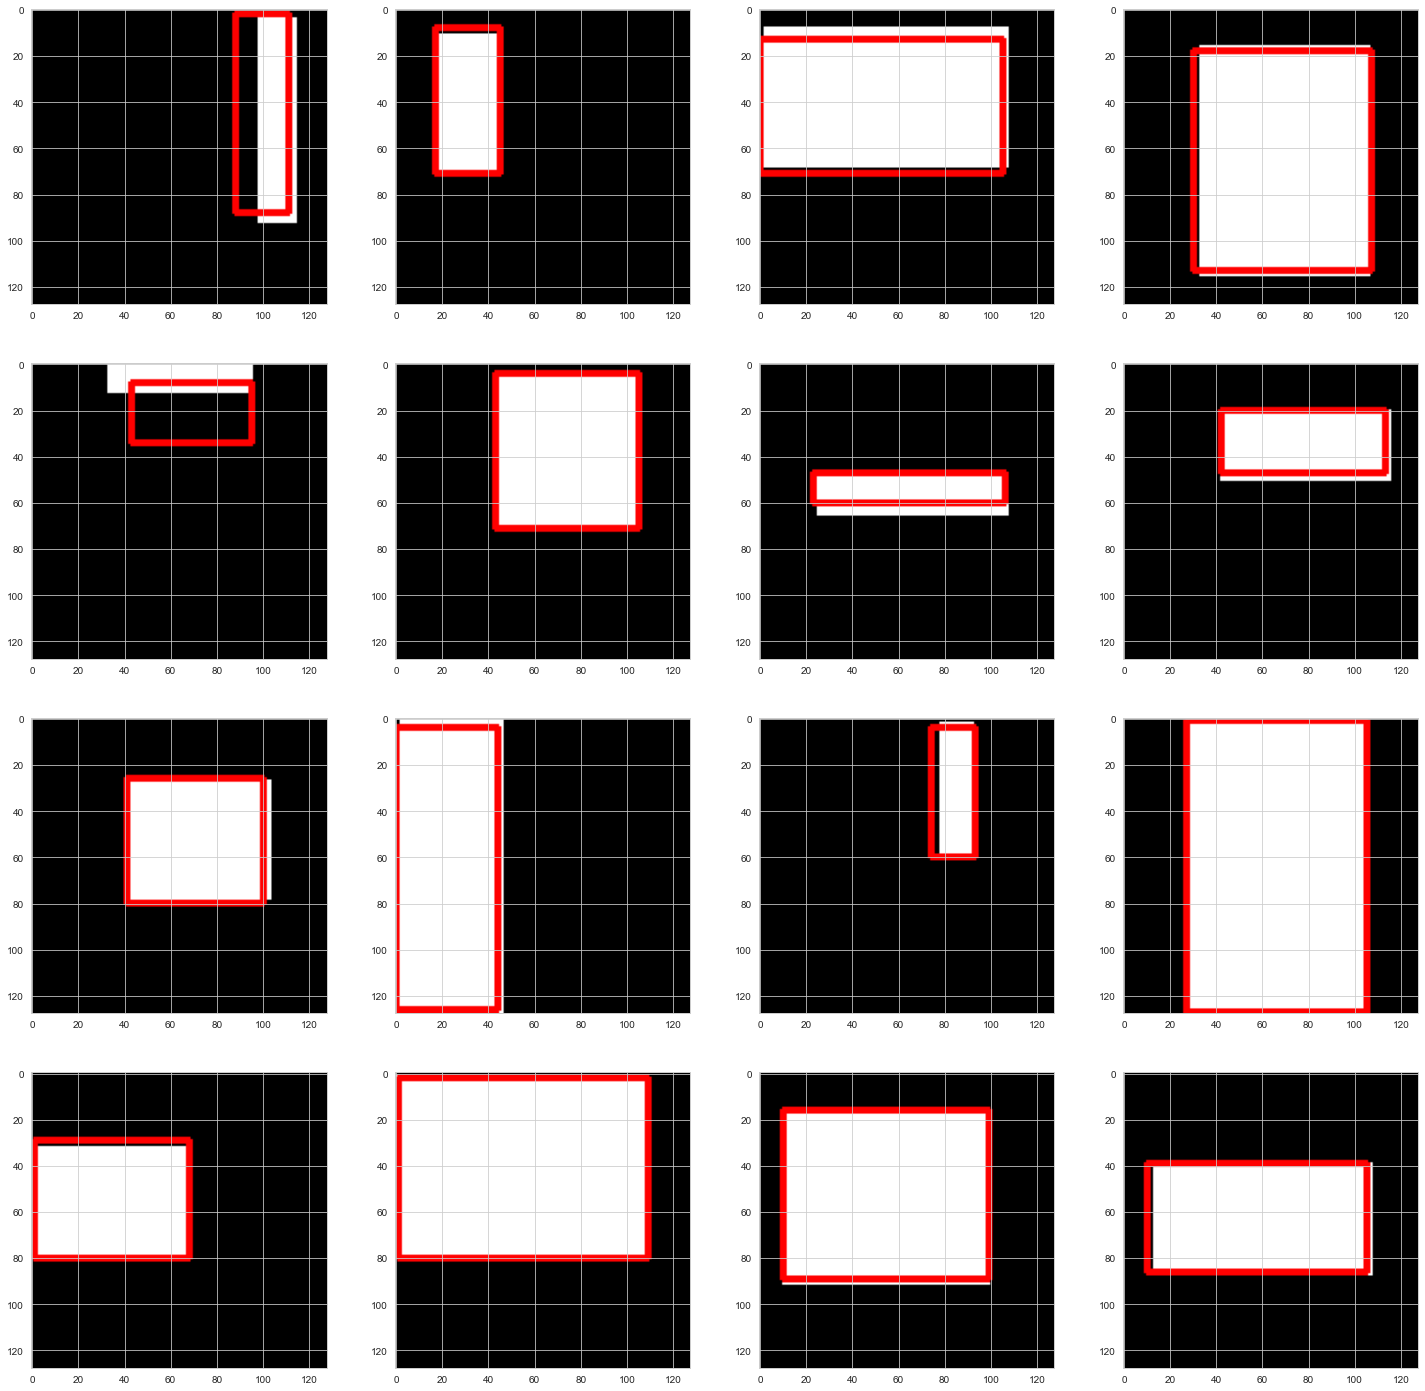

In [48]:
# Choose randomly in test set
rows = 4
cols = 4
nbr_samples = rows*cols
rand_index = np.random.choice(X_test.shape[0], size=nbr_samples, replace=False)

# Plot input with the prediction (boxes in red)
print('Test loss:', score[0]) 
plt.figure(figsize=(25,25))
for n, i in enumerate(rand_index):
    x1,y1,x2,y2 = np.split(prediction[i], indices_or_sections=4)
    im = convert_grayscale_to_rgb(X_test[i])
    im = cv2.rectangle(im,(int(x1),int(y1)),(int(x2),int(y2)), 1, 2)
    plt.subplot2grid((rows, cols),(n//cols, n%cols))
    plt.imshow(im)
plt.savefig('./pictures/predictions.png')

## Source of Inaccuracy <a class="anchor" id="inacc"></a>

Create a table with losses according to the dimension of the object.

Those losses are leveled in categories to obtain more readable results.

In [43]:
df = pd.DataFrame(columns=['Constraining dimension', 'error_val', 'Error', 'Height', 'Width'])
df = df.astype({'Constraining dimension': np.float})
df = df.astype({'error_val': np.float})
df = df.astype({'Height': np.float})
df = df.astype({'Width': np.float})

for i, pred in enumerate(prediction):
    error = abs(y_test[i] - (pred/scale))
    h = (y_test[i,3] - y_test[i,1]) * scale
    w = (y_test[i,2] - y_test[i,0]) * scale
    m = min(h,w)
    if any(error > 0.3):
        kind = "big"
    elif any(error > 0.2):
        kind = "medium"
    elif any(error > 0.1):
        kind = "low"
    else:
        kind = "negligeable"
    d_row = {'Constraining dimension':m, 'error_val':sum(error), 'Error':kind, 'Height':h, 'Width':w}
    df = df.append(d_row, ignore_index=True)

#### Histogram of the erros according to the restraining (smallest) object's dimension

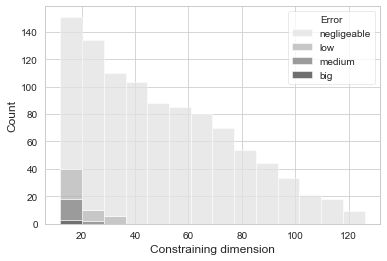

In [44]:
sns.set_style("whitegrid")
sns.histplot(df, x='Constraining dimension', hue='Error', palette=sns.color_palette("Greys", 4), multiple="stack")
plt.savefig('./pictures/error_from_size_bar.png')

#### Scatter plot of the erros according to height and width of the object

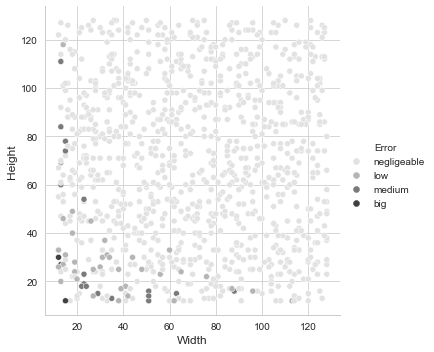

In [45]:
sns.set_style("whitegrid")
sns.relplot(data=df, x="Width", y="Height", palette=sns.color_palette("Greys", 4),
            hue="Error", hue_order=["negligeable", "low", "medium", "big"])
plt.savefig('./pictures/error_from_size_scatter.png')

> These results clearly demonstrate an anti-correlation between the prediction error and the size of the object, the
> smaller the object, the greater the error probability.
>
> The most logical cause that comes in mind is the max pooling. Since the max pooling is mapping an image into a
> smaller one, it prevents to perfectly reverse the transformation. Consequently, this generates a slight inaccuracy on the
> position of pixel. By the nature of the metric used for box regression (IoU), a small inaccuracy has much more impact
> on a small object than a large one. Therefore, this architecture is not particularly suitable for box regression problem.
>
> It is interesting to look into the literature to find a new architectures and designs, as **Region of Interest** (RoI) to further improve the model. 